✅ Loaded MNIST locally!
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Froze base model layers.
Starting training...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 94s 110ms/step - accuracy: 0.7497 - loss: 0.7942 - val_accuracy: 0.9437 - val_loss: 0.1802
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 97s 115ms/step - accuracy: 0.9292 - loss: 0.2279 - val_accuracy: 0.9605 - val_loss: 0.1263
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 102s 121ms/step - accuracy: 0.9479 - loss: 0.1688 - val_accuracy: 0.9640 - val_loss: 0.1067
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 96s 114ms/step - accuracy: 0.9547 - loss: 0.1443 - val_accuracy: 0.9635 - val_loss: 0.1086
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 97s 115ms/step - accuracy: 0.9568 - loss: 0.1323 - val_accuracy: 0.9682 - val_loss: 0.0901
Initial training complete.
Unfroze last 4 layers of base model for fine-tuning.
Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 399s 470ms/step - accuracy: 0.9654 - loss: 0.1064 - val_accuracy: 0.9842 - val_loss: 0.0487
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 366s 434ms/step - accuracy: 0.9842 - loss: 0.0493 - val_accuracy: 0.9867 - val_loss: 0.0428
Epoch 3

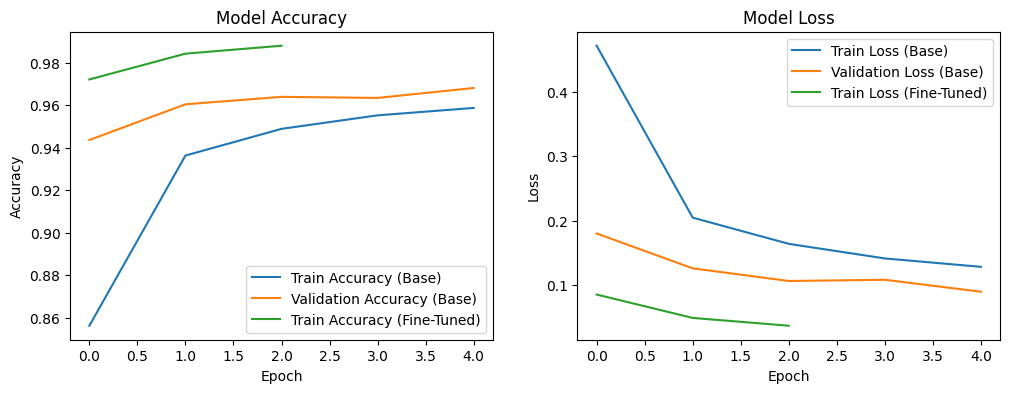

In [1]:
# a) Load in a pre-trained CNN model trained on a large dataset
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

with np.load(r"C:\Users\kusha\Desktop\mnist_dataset.npz") as data:
    x_train = data["X_train"]
    y_train = data["y_train"]
    x_test = data["X_test"]
    y_test = data["y_test"]

print("✅ Loaded MNIST locally!")
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

# b) Freeze parameters (weights) in model's lower convolutional layers
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)

x_train = tf.image.resize(x_train, [32, 32])
x_test = tf.image.resize(x_test, [32, 32])

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False
print("Froze base model layers.")

# c) Add custom classifier with trainable layers
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')  # 10 classes in MNIST
])

# d) Train classifier layers on training data
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Starting training...")
model.summary()

history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)
print("Initial training complete.")

# e) Fine-tune hyperparameters and unfreeze more layers
for layer in base_model.layers[-4:]:
    layer.trainable = True
print("Unfroze last 4 layers of base model for fine-tuning.")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

print("Fine-tuning complete.")

# f) Evaluate and plot results
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy after fine-tuning: {test_acc:.4f}")
print(f"Test Loss after fine-tuning: {test_loss:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy (Base)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Base)')
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy (Fine-Tuned)')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (Base)')
plt.plot(history.history['val_loss'], label='Validation Loss (Base)')
plt.plot(fine_tune_history.history['loss'], label='Train Loss (Fine-Tuned)')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step


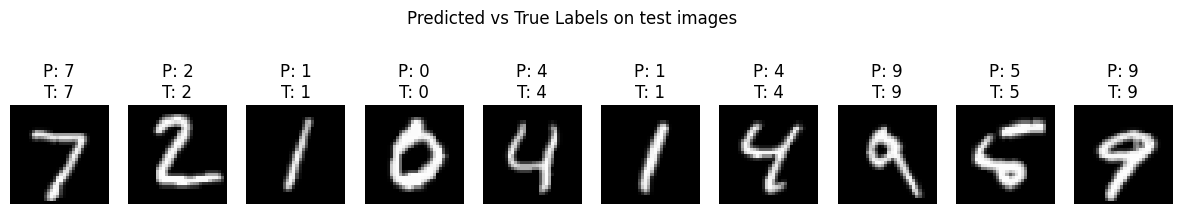

In [4]:
# Predict on test set
predictions = model.predict(x_test)
pred_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Show first 10 test images with predicted and true labels
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[i])
    plt.title(f"P: {pred_labels[i]}\nT: {true_labels[i]}")
    plt.axis('off')
plt.suptitle("Predicted vs True Labels on test images")
plt.show()